<a href="https://colab.research.google.com/github/jan-1995/Trajectory_Ctrl_LQR/blob/main/TRAJECTORY_CONTROL_QC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING ALL THE IMPORTANT LIBRARIES**

In [1]:
from math import cos, sin
import numpy as np
from random import random
import scipy.signal as signal
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

**PARAMETERS FOR EQUATIONS**

In [2]:
g=9.8564
Jx = 0.114700                              #Moment of Inertia w.r.t body  x
Jy = 0.057600                              #Moment of Inertia w.r.t body  y
Jz = 0.171200                              #Moment of Inertia w.r.t body  z                           #(w1)/2;
m=1.56
phi_c = 0                                  # psi commanded
theta_c=0                                  # theta commanded
r_c  = 0                                   # yaw rate commanded

**SIMULATION TIME**

In [3]:
Ts=0.05
Tfinal=15
dt = Ts
Tsteps = Tfinal/dt # number of frames
frames = int(Tsteps)

In [4]:
pn = 0 #north
pe = 0 #east
pd = 0 #down

# velocities
u = 0 #wrt north
v = 0 #wrt east
w = 0 #wrt down

# angles
phi = 0   #roll
theta = 0 #pitch
psi = 0   #yaw

# angular rates
p = 0 #wrt roll
q = 0 #wrt pitch
r = 0 #wrt yaw
F=m*g
T_phi=0
T_theta=0
T_psi=0

states = np.array([pn, pe, pd, u, v, w, phi, theta, psi, p, q, r])  # states Vector


**DATA COLLECTION FOR TRAJECTORIES AND PLOTS**

In [5]:
pn_data = []
pe_data = []
h_data = []
vn_data = []
ve_data = []
vd_data = []
phi_data = []
theta_data = []
psi_data = []
p_data = []
q_data = []
r_data = []
pnr_data=[]
per_data=[]
hr_data=[]
phi_c_data=[]
theta_c_data=[]
psi_c_data=[]

r_c_data=[]
u_c_data=[]
v_c_data=[]
w_c_data=[]

error_phi=[]
error_theta=[]
error_psi=[]
error_r=[]
error_pn=[]
error_pe=[]
error_pd=[]
error_u=[]
error_v=[]
error_w=[]


#####NOISY DATA #############

pnoisy=[]
qnoisy=[]
rnoisy=[]
error_p_noisy=[]




**R_B_V**

In [6]:
def rot_mat_bod2veh(phi, theta, psi):


  R_b_v=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
                  [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
                  [-sin(theta),         sin(phi)*cos(theta),                            cos(phi)*cos(theta)]])
  return R_b_v

**R_NED_TO_XYZ**

In [7]:
def axes_ned2yxz():
  
  A_ned = [[0, 1, 0],
           [1, 0, 0],
           [0, 0, -1]]
  return A_ned

**GYRO TO BODY**

In [8]:
def der_ang2rates(phi, theta):
  
  sPh = np.sin(phi)
  cPh = np.cos(phi)
  sT = np.sin(theta)
  cT = np.cos(theta)
  TT = np.tan(theta)
  d_a_r = [[1, sPh*TT, cPh*TT],
           [0, cPh,    -sPh],
           [0, sPh/cT, cPh/cT]]
  return d_a_r

**PID CONTROLLER**

In [9]:
# def pid_control(y, y_c, y_dot, kp, kd, ki):

#   err = y_c - y
#   u = kp*err - kd*y_dot + ki*err*Ts

#   return u

**YAW CONTROLL**

In [10]:
# def yaw_control(r, r_c, kp_att):

#   u = kp_att*(r_c-r)
#   return u

**ATTITUDE LQR**

In [11]:
#Attitude_Control_LQR
def attitude_LQR():
  A=np.array([[0, 1, 0, 0, 0 ],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]])
  
  B=np.array([[0, 0, 0],
              [1/Jx, 0, 0],
              [0, 0, 0],
              [0, 1/Jy, 0],
              [0, 0, 1/Jz]])

  Q=np.array([[10, 0, 0, 0, 0],
              [0, 0.1, 0, 0, 0],
              [0, 0, 10, 0, 0],
              [0, 0, 0, 0.1, 0],
              [0, 0, 0, 0, 1]])
  
  R=np.array([[0.1, 0, 0], 
              [0, 0.1, 0],
              [0, 0, 0.1]])

  P=np.matrix(linalg.solve_continuous_are(A, B, Q, R))
  K2=np.matrix(linalg.inv(R)*(B.T*P))
  eigVals, eigVecs = linalg.eig(A-B*K2)

  return K2

**ATTITUDE LQR CONTROLLER**

In [12]:
def controller_LQR_roll(y, K):

  T_phi=-K[0,0]*y[0]-K[0,1]*y[1]-K[0,2]*y[2]-K[0,3]*y[3]-K[0,4]*y[4]    
  return T_phi

def controller_LQR_pitch(y, K):
  T_theta=-K[1,0]*y[0]-K[1,1]*y[1]-K[1,2]*y[2]-K[1,3]*y[3]-K[1,4]*y[4]   
  return T_theta

def controller_LQR_yaw(y, K):
  T_psi=-K[2,0]*y[0]-K[2,1]*y[1]-K[2,2]*y[2]-K[2,3]*y[3]-K[2,4]*y[4]    
  return T_psi

**TRAJECTORY LQR**

In [13]:
def trajectory_LQR():

  A=np.array([[0,0,0,1,0,0,0],
              [0,0,0,0,1,0,0],
              [0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0]])
  
  B=np.array([[0,0,0,0],
              [0,0,0,0],
              [0,0,0,0],
              [1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,1]])  
  q1=.03
  q2=.03
  q3=.03
  q4=.05
  q5=.05


  Q=np.array([[1/(q1**2),0,0,0,0,0,0],
              [0,1/(q2**2),0,0,0,0,0],
              [0,0,1/(q3**2),0,0,0,0],
              [0,0,0,1/(q4**2),0,0,0],
              [0,0,0,0,1/(q5**2),0,0],
              [0,0,0,0,0   ,20,0],
              [0,0,0,0,0,     0,1]])

  r1=.2

  r2=np.sqrt(.1)
  R=np.array([[1/r1**2,0,0,0],
              [0,1/r1**2,0,0],
              [0,0,1/r2**2,0],
              [0,0,0,1/r2**2]])

  P=np.matrix(linalg.solve_continuous_are(A,B,Q,R))
  K=np.matrix(linalg.inv(R)*(B.T*P))

  

  return K





**TRAJECTORY DEFINITION**

In [14]:
def trajectory(t):
  
  
  # ## Condition 1##
  # a=9
  # b=9
  # c=0
  # n=-0.75
  # T=5
  # w1=2*np.pi/T
  # w2=w1/2
  # w3=w1

  ## Condition 2##
  a=1.5
  b=0.75
  c=0.5
  n=-0.75
  T=10
  w1=2*np.pi/T
  w2=w1/2
  w3=w1

  # ## Condition 3##
  # a=0.75
  # b=0.75
  # c=0
  # n=-0.75
  # T=10
  # w1=2*np.pi/T
  # w2=w1
  # w3=w1

  ##Unique Trajectory##

  # a=3
  # b=3
  # c=2
  # n=-3
  # T=10
  # w1=2*np.pi/T
  # w2=w1
  # w3=w1

   
  ytraj=np.array([[a*cos(w2*t)], [b*sin(w1*t)], [n+c*sin(w3*t)], [np.pi/4]])

  ydottraj=np.array([[-a*w2*sin(w2*t)], [b*w1*cos(w1*t)], [c*w3*cos(w3*t)], [0]])
  yddottraj=np.array([[-a*w2*w2*cos(w2*t)], [-b*w1*w1*sin(w1*t)], [-c*w3*w3*sin(w3*t)], [0]])


# Commanded U and X to the LQR controller

  ur=np.array([yddottraj[0],yddottraj[1],yddottraj[2]-g,ydottraj[3]])   
  xr=np.array([ytraj[0],ytraj[1],ytraj[2],ydottraj[0],ydottraj[1],ydottraj[2],ytraj[3]])

## Desired states coming from 

  pnr_data.append(xr[0,0])
  per_data.append(xr[1,0])
  hr_data.append(xr[2,0])
   

  return [ur, xr]

**TRAJECTORY CONTROL**

In [15]:
#Inverse maping
def rot_psi (psi):
    R_psi=np.array([[cos(psi), sin(psi), 0],
         [-sin(psi), cos(psi), 0],
         [0, 0, 1]])
    return R_psi

def trajectory_control(states, xr, ur, K):
  
  
  pn=states[0]
  pe=states[1]
  pd=states[2]
  u=states[3]
  v=states[4]
  w=states[5]
  phi=states[6]
  theta=states[7]
  psi=states[8]
  p=states[9]
  q=states[10]
  r=states[11]

  x=np.array([[pn], [pe], [pd], [u], [v], [w], [psi]])

  dx=x-xr

  # TRAJECTORY LQR CONTROLLER INPUT K COMES HERE

  #ur = reference u from the trajectory
  #uc= commanded input 
  du=-np.matmul(K,dx)


  uc=du+ur
  

  up=np.array([uc[0,0], uc[1,0], uc[2,0]])

  
  #A=np.matmul(up.transpose(), up)
  #display('A = ',A)
  
  F=m*np.sqrt(np.matmul(up.transpose(), up)) 


  


  R_psi=rot_psi(psi)
  z=-np.matmul(R_psi, up)*m/F

  

  
  # display('z =',z)
  phi_c   =np.arcsin(-z[1])
  theta_c =np.arctan2(z[0], z[2]) 
  r_c     =uc[3,0]*cos(phi)*cos(theta)-q*sin(phi)

 

  return [F, float(phi_c), float(theta_c), float(r_c)]



**MATHEMATICAL MODELING OF QUADROTOR (USED)**

In [16]:
# Dynamics of the Quadrotor
def quad_dyna( t, y, F, T_phi, T_theta, T_psi):
  pn=y[0]
  pe=y[1]
  pd=y[2]
  u=y[3]
  v=y[4]
  w=y[5]
  phi=y[6]
  theta=y[7]
  psi=y[8]
  p=y[9]
  q=y[10]
  r=y[11]

#accelerometer input with noise

  A=0.3*np.random.normal(0,10,1)
  az=-F/m + A[0]


  R_b_w=rot_mat_bod2veh(phi,theta,psi)
  # ThrustVecBody=np.array([0, 0, -F/m]).T
  ThrustVecBody=np.array([0, 0, az]).T
  gravity_vec=np.array([0, 0, g]).T
  Acci=np.matmul(R_b_w,ThrustVecBody)+gravity_vec


  Angv=np.matmul(np.array([[1,np.sin(phi)*np.tan(theta),np.cos(phi)*np.tan(theta)],
                           [0,np.cos(phi),-np.sin(phi)],
                           [0,np.sin(phi)/np.cos(theta),np.cos(phi)/np.cos(theta)]]),np.array([p,q,r]).T)
  Angb=np.array([T_phi/Jx,T_theta/Jy,T_psi/Jz]).T + np.array([q*r*(Jy-Jz)/Jx,p*r*(Jz-Jx)/Jy,q*p*(Jx-Jy)/Jz]).T

  pn_dot=u
  pe_dot=v
  pd_dot=w
  phi_dot=Angv[0]
  theta_dot=Angv[1]
  psi_dot=Angv[2]
  u_dot=Acci[0]
  v_dot=Acci[1]
  w_dot=Acci[2]
  p_dot=Angb[0]
  q_dot=Angb[1]
  r_dot=Angb[2]

  return [pn_dot, pe_dot, pd_dot, u_dot, v_dot, w_dot, phi_dot, theta_dot, psi_dot, p_dot, q_dot, r_dot]
  pass 

**SOLVING THE STATE SPACE EQUATIONS**

In [17]:
def step(states, Ts, i):

  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w= states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  ur, xr = trajectory(i/15)

  Kt=trajectory_LQR()
  F, phi_c, theta_c, r_c = trajectory_control(states, xr, ur, Kt)

  states1=np.array([phi-phi_c, p, theta-theta_c, q, r-r_c])

  K1=attitude_LQR()

  T_phi=controller_LQR_roll(states1, K1)
  T_theta=controller_LQR_pitch(states1, K1)
  T_psi=controller_LQR_yaw(states1, K1)

  


  phi_c_data.append(phi_c)
  theta_c_data.append(theta_c)
  r_c_data.append(r_c) 

  phi_c_data.append(phi_c)
  theta_c_data.append(theta_c)
  r_c_data.append(r_c)
  u_c_data.append(xr[3])
  v_c_data.append(xr[4])
  w_c_data.append(xr[5])
  psi_c_data.append(xr[6])

  error_phi.append(phi_c-phi)
  error_theta.append(theta_c-theta)
  error_r.append(r_c-r)
  error_pn.append(xr[0]-pn)
  error_pe.append(xr[1]-pe)
  error_pd.append(xr[2]-pd)
  error_u.append(xr[3]-u)
  error_v.append(xr[4]-v)
  error_w.append(xr[5]-w)
  error_psi.append(xr[6]-psi)


  ##Gyro Function
  pnoise=p+np.random.normal(0,0.01,100)
  qnoise=q+np.random.normal(0,0.01,100)
  rnoise=r+np.random.normal(0,0.01,100)
  Gyro=np.array([pnoise,qnoise,rnoise])
  pnoisy.append(Gyro[0])
  qnoisy.append(Gyro[1])
  rnoisy.append(Gyro[2])

  error_p_noisy.append(Gyro[0]-p)
  # error_q_noisy.append(Gyro[1]-p)
  # error_r_noisy.append(Gyro[2]-p)
  




  
  sol = solve_ivp(lambda t, y: quad_dyna(t, y, F, T_phi, T_theta, T_psi), [0, Ts], [pn, pe, pd, u, v, w, phi, theta, psi, p, q, r], t_eval= np.linspace(0, Ts, 10))
  states = sol.y[:,-1].T
  return states

**Gyro Function**

In [18]:
# function to draw the quad
def build_quad(pn, pe, pd, phi, theta, psi):
  pn = pn
  pe = pe
  pd = pd
  phi = phi
  theta = theta
  psi = psi
  # define width to use as reference to construct the quad 
  w = 1.5

  # defining the coordinates of the end points of the quad rotors
  p1 = np.array([w, 0, 0]).T
  p2 = np.array([-w, 0, 0]).T
  p3 = np.array([0, w, 0]).T
  p4 = np.array([0, -w, 0]).T

  # converting the quadrotor points to interial frame and translating as per ned
  R=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
                  [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
                  [-sin(theta),         sin(phi)*cos(theta),                            cos(phi)*cos(theta)]])

  pos_ned = np.array([pn, pe, pd]).T #
  p1r = np.matmul(R,p1)+pos_ned
  p2r = np.matmul(R,p2)+pos_ned
  p3r = np.matmul(R,p3)+pos_ned
  p4r = np.matmul(R,p4)+pos_ned

  # changing the orientation of ned wrt yxz
  A_ned = np.array([[0, 1, 0],
                    [1, 0, 0],
                    [0, 0,-1]])
  A=A_ned
  
  p1ra = np.matmul(A,p1r)
  p2ra = np.matmul(A,p2r)
  p3ra = np.matmul(A,p3r)
  p4ra = np.matmul(A,p4r)

  # Rotor coordinates
  rot_x = [p1ra[0], p2ra[0], p3ra[0], p4ra[0]]
  rot_y = [p1ra[1], p2ra[1], p3ra[1], p4ra[1]]
  rot_z = [p1ra[2], p2ra[2], p3ra[2], p4ra[2]]

  # Arm coordinates
  arm1_x = [p1ra[0], p2ra[0]]
  arm1_y = [p1ra[1], p2ra[1]]
  arm1_z = [p1ra[2], p2ra[2]]

  arm2_x = [p3ra[0], p4ra[0]]
  arm2_y = [p3ra[1], p4ra[1]]
  arm2_z = [p3ra[2], p4ra[2]]

  w=0.5
  # defining the coordinates of the payload
  v1 = np.array([-w/3,-w/3,w/2]).T
  v2 = np.array([-w/3,-w/3,0]).T
  v3 = np.array([w/3,-w/3,0]).T
  v4 = np.array([w/3,-w/3,w/2]).T
  v5 = np.array([w/3,w/3,w/2]).T
  v6 = np.array([w/3,w/3,0]).T
  v7 = np.array([-w/3,w/3,0]).T
  v8 = np.array([-w/3,w/3,w/2]).T

  # converting the payload points to interial frame and translating as per ned
  v1r = np.matmul(R,v1)+pos_ned
  v2r = np.matmul(R,v2)+pos_ned
  v3r = np.matmul(R,v3)+pos_ned
  v4r = np.matmul(R,v4)+pos_ned
  v5r = np.matmul(R,v5)+pos_ned
  v6r = np.matmul(R,v6)+pos_ned
  v7r = np.matmul(R,v7)+pos_ned
  v8r = np.matmul(R,v8)+pos_ned

  # changing the orientation of ned wrt yxz
  v1ra = np.matmul(A,v1r)
  v2ra = np.matmul(A,v2r)
  v3ra = np.matmul(A,v3r)
  v4ra = np.matmul(A,v4r)
  v5ra = np.matmul(A,v5r)
  v6ra = np.matmul(A,v6r)
  v7ra = np.matmul(A,v7r)
  v8ra = np.matmul(A,v8r)

  # defining the faces of the payload
  f1_x=[v1ra[0], v2ra[0], v3ra[0], v4ra[0], v1ra[0]]
  f1_y=[v1ra[1], v2ra[1], v3ra[1], v4ra[1], v1ra[1]]
  f1_z=[v1ra[2], v2ra[2], v3ra[2], v4ra[2], v1ra[2]]
  f2_x=[v5ra[0], v6ra[0], v7ra[0], v8ra[0], v5ra[0]]
  f2_y=[v5ra[1], v6ra[1], v7ra[1], v8ra[1], v5ra[1]]
  f2_z=[v5ra[2], v6ra[2], v7ra[2], v8ra[2], v5ra[2]]
  f3_x=[v4ra[0], v5ra[0], v6ra[0], v3ra[0], v4ra[0]]
  f3_y=[v4ra[1], v5ra[1], v6ra[1], v3ra[1], v4ra[1]]
  f3_z=[v4ra[2], v5ra[2], v6ra[2], v3ra[2], v4ra[2]]
  f4_x=[v1ra[0], v8ra[0], v7ra[0], v2ra[0], v1ra[0]]
  f4_y=[v1ra[1], v8ra[1], v7ra[1], v2ra[1], v1ra[1]]
  f4_z=[v1ra[2], v8ra[2], v7ra[2], v2ra[2], v1ra[2]]

  return rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z

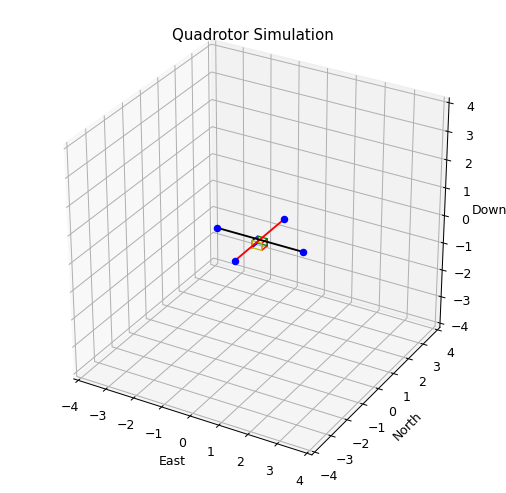

In [19]:
#Intial Plot
fig = plt.figure(figsize=(7,7), dpi=90)
ax = fig.add_subplot(1, 1, 1,projection='3d')
ax.set_xlim((-4,4))            
ax.set_ylim((-4,4))
ax.set_zlim((-4,4))
ax.set_xlabel('East')
ax.set_ylabel('North')
ax.set_zlabel('Down')
ax.set_title('Quadrotor Simulation')

rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(pn, pe, pd, phi, theta, psi)

# Collecting data for trajectories and plots
pn_data.append(states[0])
pe_data.append(states[1])
h_data.append(-states[2])
vn_data.append(states[3])
ve_data.append(states[4])
vd_data.append(states[5])
phi_data.append(states[6])
theta_data.append(states[7])
psi_data.append(states[8])
p_data.append(states[9])
q_data.append(states[10])
r_data.append(states[11])
# payload
face1, = ax.plot(f1_x, f1_y, f1_z, 'b', lw=1.1)
face2, = ax.plot(f2_x, f2_y, f2_z, 'r', lw=1.1)
face3, = ax.plot(f3_x, f3_y, f3_z, 'g', lw=1.1)
face4, = ax.plot(f4_x, f4_y, f4_z, 'y', lw=1.1)

# arms and rotors
arm1, = ax.plot(arm1_x, arm1_y, arm1_z, 'r-', lw=1.5)
arm2, = ax.plot(arm2_x, arm2_y, arm2_z, 'k-', lw=1.5)
rotor, = ax.plot(rot_x, rot_y, rot_z, 'bo', ms = 5)

# trajectory
traj, = ax.plot(pe_data, pn_data, h_data, 'g:', lw=1)
traj1, = ax.plot(per_data, pnr_data, hr_data, 'r:', lw=1)



In [20]:
def drawframe(i):
  global states
  states = step(states, dt,i)
  pn = states[0]
  pe = states[1]
  pd = -states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  
  rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(pn, pe, pd, phi, theta, psi)

  pn_data.append(states[0])
  pe_data.append(states[1])
  h_data.append(states[2])
  vn_data.append(states[3])
  ve_data.append(states[4])
  vd_data.append(states[5])
  phi_data.append(states[6])
  theta_data.append(states[7])
  psi_data.append(states[8])
  p_data.append(states[9])
  q_data.append(states[10])
  r_data.append(states[11])

  face1.set_data(f1_x, f1_y)
  face1.set_3d_properties(f1_z)
  face2.set_data(f2_x, f2_y)
  face2.set_3d_properties(f2_z)
  face3.set_data(f3_x, f3_y)
  face3.set_3d_properties(f3_z)
  face4.set_data(f4_x, f4_y)
  face4.set_3d_properties(f3_z)

  arm1.set_data(arm1_x, arm1_y)
  arm1.set_3d_properties(arm1_z)
  arm2.set_data(arm2_x, arm2_y)
  arm2.set_3d_properties(arm2_z)
  rotor.set_data(rot_x, rot_y)
  rotor.set_3d_properties(rot_z)

  traj.set_data(pe_data, pn_data)
  traj.set_3d_properties(h_data)
  
  traj1.set_data(per_data, pnr_data)
  traj1.set_3d_properties(hr_data)


  return face1, face2, face3, face4, arm1, arm2, rotor, traj, traj1

In [21]:
def state_plot(i):
  global states
  states = step(states, dt, i)
  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  pn_data.append(states[0])
  pe_data.append(states[1])
  h_data.append(-states[2])
  vn_data.append(states[3])
  ve_data.append(states[4])
  vd_data.append(states[5])
  phi_data.append(states[6])
  theta_data.append(states[7])
  psi_data.append(states[8])
  p_data.append(states[9])
  q_data.append(states[10])
  r_data.append(states[11])

  return pn_data, pe_data, h_data, vn_data, ve_data, vd_data, phi_data, theta_data, psi_data, p_data, q_data, r_data


In [22]:

ax.set_xlabel('East(x)')
ax.set_ylabel('North(y)')
ax.set_zlabel('Down(z)')
ax.set_title('Quadrotor Simulation')
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=frames, interval=40, blit=True)
HTML(anim.to_html5_video())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


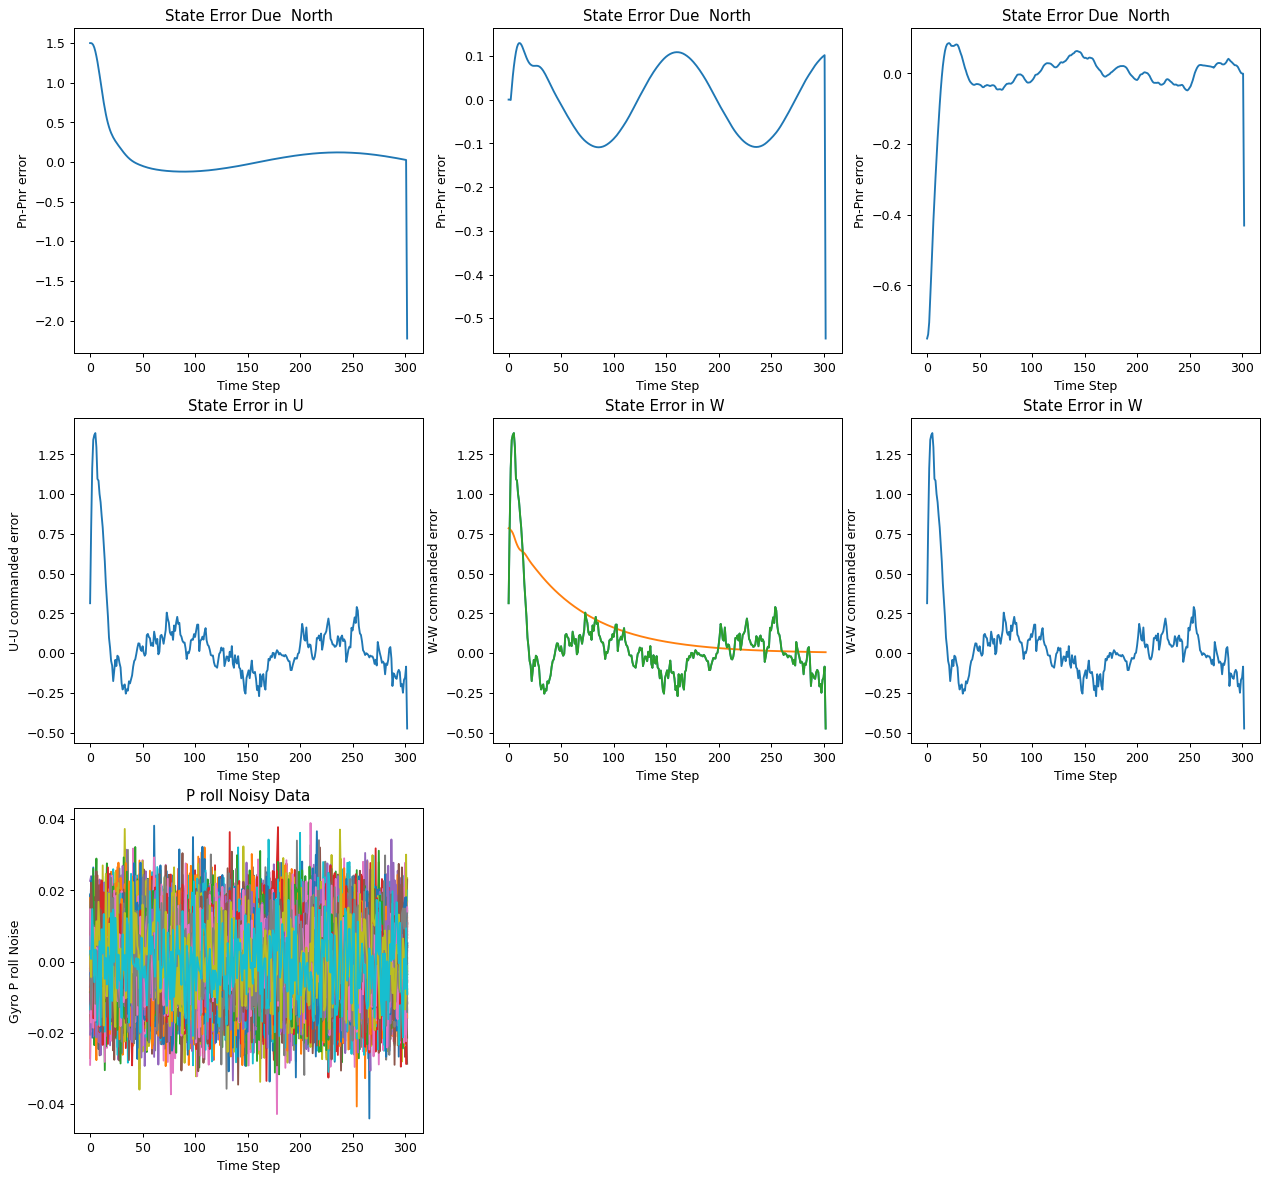

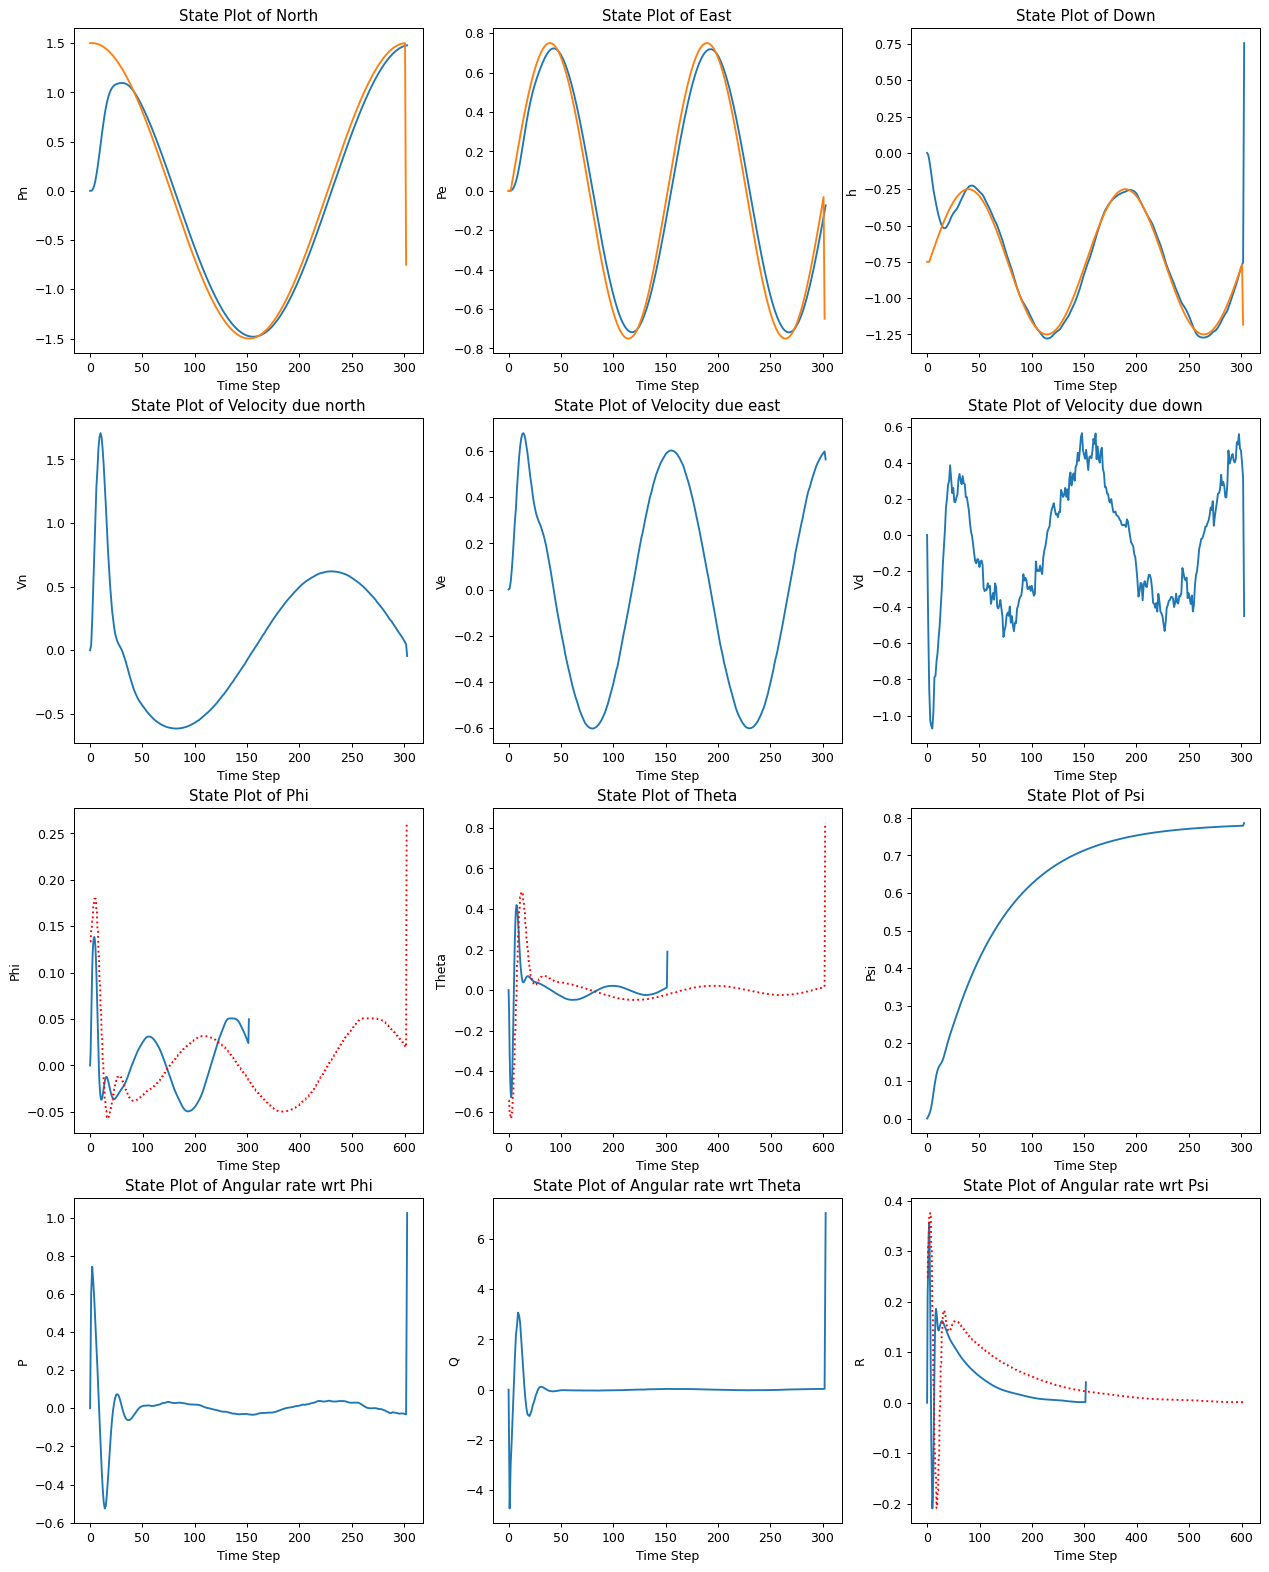

In [23]:
# Figure to plot the states against time step
pn_data1, pe_data1, h_data1, vn_data1, ve_data1, vd_data1, phi_data1, theta_data1, psi_data1, p_data1, q_data1, r_data1 = state_plot(100)

################## STATE ERROR PLOTS ################################################################################################################

fig2 = plt.figure(figsize=(17,22), dpi=90)
ax13 = fig2.add_subplot(4, 3, 1)
ax13.set_xlabel('Time Step')
ax13.set_ylabel('Pn-Pnr error')
ax13.set_title('State Error Due  North')
EN = ax13.plot(range(len(pn_data1)-1),error_pn)


ax14 = fig2.add_subplot(4, 3, 2)
ax14.set_xlabel('Time Step')
ax14.set_ylabel('Pn-Pnr error')
ax14.set_title('State Error Due  North')
EE = ax14.plot(range(len(pe_data1)-1),error_pe)

ax15 = fig2.add_subplot(4, 3, 3)
ax15.set_xlabel('Time Step')
ax15.set_ylabel('Pn-Pnr error')
ax15.set_title('State Error Due  North')
ED = ax15.plot(range(len(h_data1)-1),error_pd)


ax16 = fig2.add_subplot(4, 3, 4)
ax16.set_xlabel('Time Step')
ax16.set_ylabel('U-U commanded error')
ax16.set_title('State Error in U ')
EU = ax16.plot(range(len(vn_data)-1),error_w)

ax16 = fig2.add_subplot(4, 3, 5)
ax16.set_xlabel('Time Step')
ax16.set_ylabel('V-V commanded error')
ax16.set_title('State Error in V ')
EV = ax16.plot(range(len(ve_data)-1),error_w)

ax16 = fig2.add_subplot(4, 3, 6)
ax16.set_xlabel('Time Step')
ax16.set_ylabel('W-W commanded error')
ax16.set_title('State Error in W ')
EW = ax16.plot(range(len(vd_data)-1),error_w)

ax16 = fig2.add_subplot(4, 3, 5)
ax16.set_xlabel('Time Step')
ax16.set_ylabel('W-W commanded error')
ax16.set_title('State Error in W ')
EPSI = ax16.plot(range(len(psi_data)-1),error_psi)

ax16 = fig2.add_subplot(4, 3, 5)
ax16.set_xlabel('Time Step')
ax16.set_ylabel('W-W commanded error')
ax16.set_title('State Error in W ')
EU = ax16.plot(range(len(vd_data)-1),error_w)

ax17 = fig2.add_subplot(4, 3, 7)
ax17.set_xlabel('Time Step')
ax17.set_ylabel('Gyro P roll Noise')
ax17.set_title('P roll Noisy Data')
GN = ax17.plot(range(len(pnoisy)),error_p_noisy)




################## STATE  PLOTS ################################################################################################################



fig1 = plt.figure(figsize=(17,22), dpi=90)
ax1 = fig1.add_subplot(4, 3, 1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Pn')
ax1.set_title('State Plot of North')
pn1 = ax1.plot(range(len(pn_data1)),pn_data1)
pnr = ax1.plot(range(len(pnr_data)),pnr_data)




ax2 = fig1.add_subplot(4, 3, 2)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Pe')
ax2.set_title('State Plot of East')
pe1 = ax2.plot(range(len(pe_data1)),pe_data1)
per = ax2.plot(range(len(per_data)),per_data)

ax3 = fig1.add_subplot(4, 3,3)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('h')
ax3.set_title('State Plot of Down')
h1 = ax3.plot(range(len(h_data1)),h_data1)
hr = ax3.plot(range(len(hr_data)),hr_data)


ax4 = fig1.add_subplot(4, 3, 4)
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Vn')
ax4.set_title('State Plot of Velocity due north')
vn1 = ax4.plot(range(len(vn_data1)),vn_data1)


ax5 = fig1.add_subplot(4, 3, 5)
ax5.set_xlabel('Time Step')
ax5.set_ylabel('Ve')
ax5.set_title('State Plot of Velocity due east')
ve1 = ax5.plot(range(len(ve_data1)),ve_data1)


ax6 = fig1.add_subplot(4, 3, 6)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('Vd')
ax6.set_title('State Plot of Velocity due down')
vd1 = ax6.plot(range(len(vd_data1)),vd_data1)


ax7 = fig1.add_subplot(4, 3, 7)
ax7.set_xlabel('Time Step')
ax7.set_ylabel('Phi')
ax7.set_title('State Plot of Phi')
phi1 = ax7.plot(range(len(phi_data1)),phi_data1)
phi_c1 = ax7.plot(range(len(phi_c_data)),phi_c_data,'r:')


ax8 = fig1.add_subplot(4, 3, 8)
ax8.set_xlabel('Time Step')
ax8.set_ylabel('Theta')
ax8.set_title('State Plot of Theta')
theta1 = ax8.plot(range(len(theta_data1)),theta_data1)
theta_c1 = ax8.plot(range(len(theta_c_data)),theta_c_data,'r:')


ax9 = fig1.add_subplot(4, 3, 9)
ax9.set_xlabel('Time Step')
ax9.set_ylabel('Psi')
ax9.set_title('State Plot of Psi')
psi1 = ax9.plot(range(len(psi_data1)),psi_data1)


ax10 = fig1.add_subplot(4, 3, 10)
ax10.set_xlabel('Time Step')
ax10.set_ylabel('P')
ax10.set_title('State Plot of Angular rate wrt Phi')
p1 = ax10.plot(range(len(p_data1)),p_data1)


ax11 = fig1.add_subplot(4, 3, 11)
ax11.set_xlabel('Time Step')
ax11.set_ylabel('Q')
ax11.set_title('State Plot of Angular rate wrt Theta')
q1 = ax11.plot(range(len(q_data1)),q_data1)

ax12 = fig1.add_subplot(4, 3, 12)
ax12.set_xlabel('Time Step')
ax12.set_ylabel('R')
ax12.set_title('State Plot of Angular rate wrt Psi')
r1 = ax12.plot(range(len(r_data1)),r_data1)
r_c1 = ax12.plot(range(len(r_c_data)),r_c_data,'r:')

